# Looking at birds from California

https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/

In [1]:
import pandas as pd


def _convert_time(ts: str) -> float:
    """Convert hh:mm strings into hours since midnight."""
    try:
        hour, minute = ts.split(":")
        return int(hour) + int(minute) / 60
    except:
        # xx:xx
        return float("nan")


df = pd.read_csv("../data/raw/birdclef-2022/train_metadata.csv")
df["hour"] = df.time.apply(_convert_time)
subset_df = df[["primary_label", "latitude", "longitude", "hour"]].dropna()
subset_df

,primary_label,latitude,longitude,hour
0,afrsil1,12.3910,-1.4930,8.00
1,afrsil1,19.8801,-155.7254,8.50
2,afrsil1,16.2901,-16.0321,11.50
3,afrsil1,17.0922,54.2958,11.00
4,afrsil1,21.4581,-157.7252,16.50
...,...,...,...,...
14847,zebdov,22.6499,120.2872,8.60
14848,zebdov,1.4168,103.7287,8.00
14849,zebdov,1.4347,103.7043,9.00
14850,zebdov,3.3508,101.2451,11.25


In [2]:
from cartopy.io import shapereader

reader = shapereader.Reader(
    shapereader.natural_earth(
        resolution="50m", category="cultural", name="admin_1_states_provinces"
    )
)
california = [
    s
    for s in reader.records()
    if s.attributes["admin"] == "United States of America"
    and s.attributes["name"] == "California"
][0]

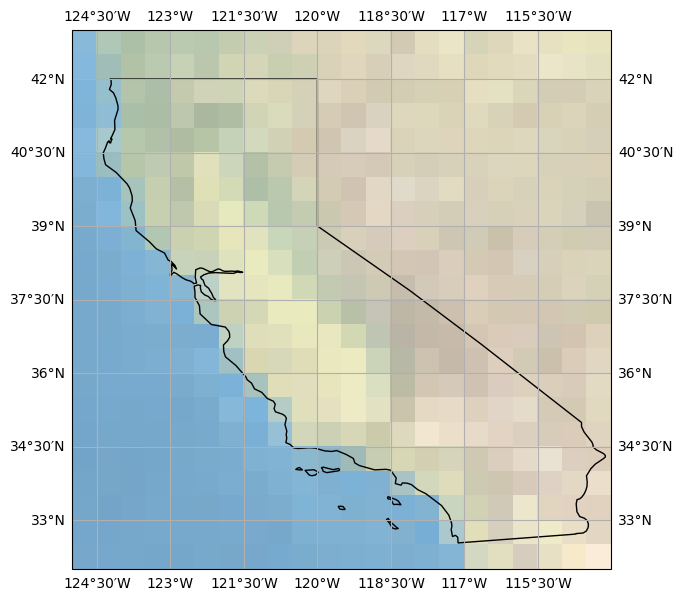

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(
    cfeature.ShapelyFeature([california.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)
ax.stock_img()
ax.set_xlim([-125, -114])
ax.set_ylim([32, 43])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

In [4]:
from shapely.geometry import Point

# check if a point is inside a polygon or not
california.geometry.contains(Point(-118.2437, 34.0522))

True

In [5]:
points_in_ca = subset_df.apply(
    lambda x: california.geometry.contains(Point(x.longitude, x.latitude)), axis=1
)
ca_df = subset_df[points_in_ca]
ca_df

,primary_label,latitude,longitude,hour
51,amewig,35.0307,-120.6205,9.500000
56,amewig,32.5640,-117.1256,9.900000
57,amewig,32.5640,-117.1256,10.250000
58,amewig,32.5640,-117.1256,10.883333
59,amewig,32.5640,-117.1256,10.750000
...,...,...,...,...
14644,wiltur,36.4728,-121.1873,8.000000
14652,wiltur,33.1349,-116.8522,10.850000
14656,wiltur,32.8706,-116.4247,5.450000
14660,wiltur,38.5321,-121.0686,5.633333


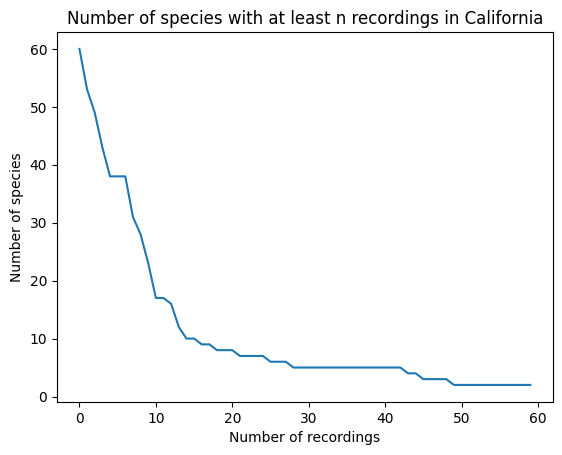

In [6]:
total_count = (ca_df.primary_label.value_counts() > 0).sum()
freq = []
for i in range(total_count):
    freq.append((ca_df.primary_label.value_counts() > i).sum())
plt.plot(freq)
plt.title("Number of species with at least n recordings in California")
plt.xlabel("Number of recordings")
plt.ylabel("Number of species")
plt.show()

In [7]:
species_subset = ca_df.primary_label.value_counts() > 10
species_subset = species_subset[species_subset].index
species_subset.shape

(17,)

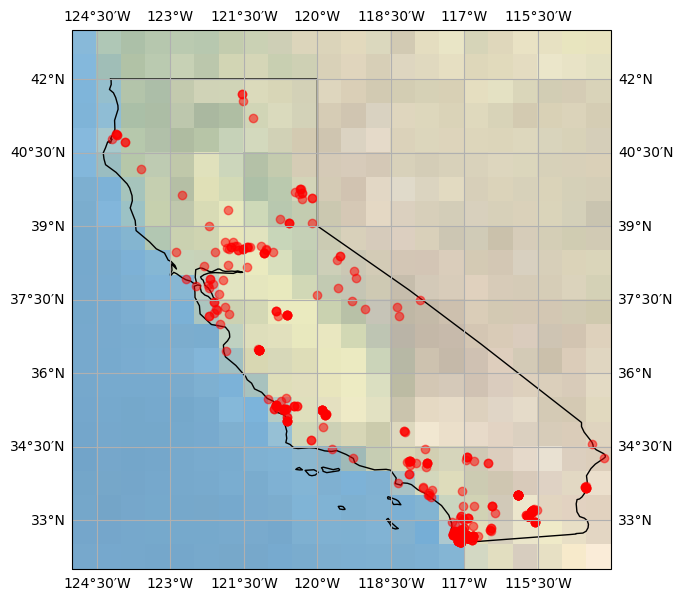

In [8]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(
    cfeature.ShapelyFeature([california.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

# add points from the california subset
for i, row in ca_df[ca_df.primary_label.isin(species_subset)].iterrows():
    ax.plot(
        row.longitude,
        row.latitude,
        "o",
        color="r",
        transform=ccrs.PlateCarree(),
        alpha=0.5,
    )

ax.stock_img()
ax.set_xlim([-125, -114])
ax.set_ylim([32, 43])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

In [9]:
def plot_species(species):
    fig = plt.figure(figsize=(12, 7))
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(
        cfeature.ShapelyFeature([california.geometry], projection),
        edgecolor="k",
        facecolor=(1, 1, 1, 0),
    )

    # add points from the california subset
    for i, row in ca_df[ca_df.primary_label == species].iterrows():
        ax.plot(
            row.longitude,
            row.latitude,
            "o",
            color="r",
            transform=ccrs.PlateCarree(),
            alpha=0.5,
        )

    ax.stock_img()
    ax.set_xlim([-125, -114])
    ax.set_ylim([32, 43])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.show()


# NOTE: there are quite a few images here, so I'll comment it out for the
# meanwhile. There are maybe a few species with different distributions, and as
# you might infer from the map of all the data points, they're mostly centered
# around population centers.
# for species in species_subset:
#     plot_species(species)

## species data per county

Lets take a look at the data on a per-county basis, since we can do things like looking at temperatures and population counts on a per-county basis. It might also make incorporating information from ESA world cover feasible.

In [10]:
# Get Minnesota counties and neighboring counties shape files
reader = shapereader.Reader(
    shapereader.natural_earth(
        resolution="10m", category="cultural", name="admin_2_counties"
    )
)
california_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(california.geometry)
    and county.geometry.difference(california.geometry).area / county.geometry.area
    < 0.1
]
california_neighbor_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(california.geometry)
    and county.geometry.difference(california.geometry).area / county.geometry.area
    > 0.5
]

In [11]:
# now we need to map each data point to a county so we can do county level statistics
def point_to_county(point, counties):
    # awful performance, but it works
    for county in counties:
        if county.geometry.contains(point):
            return county.attributes["NAME"]
    return None


# add a column with the county name
points_in_ca = subset_df.apply(
    lambda x: california.geometry.contains(Point(x.longitude, x.latitude)), axis=1
)
ca_df = subset_df[points_in_ca]
ca_df["county"] = ca_df.apply(
    lambda x: point_to_county(Point(x.longitude, x.latitude), california_counties),
    axis=1,
)
ca_df = ca_df[ca_df.county.notnull()]

/tmp/ipykernel_6549/3084743327.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df["county"] = ca_df.apply(


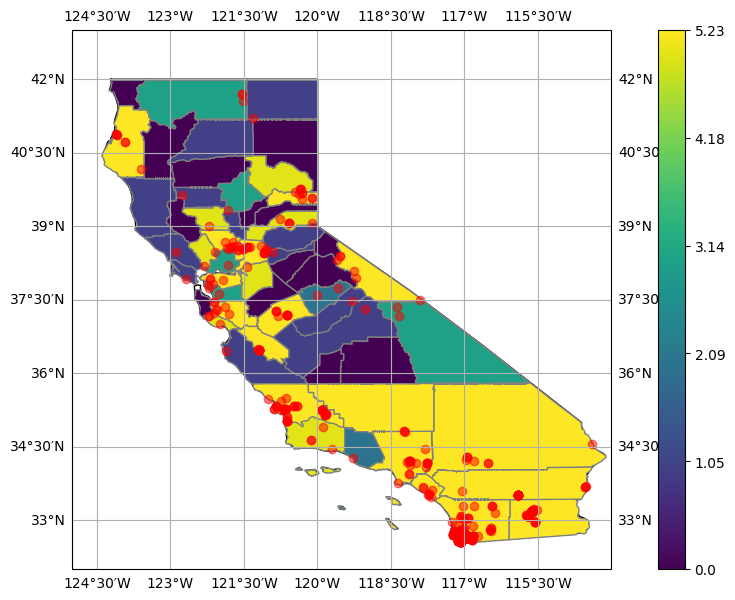

In [12]:
import numpy as np

# plot county data and boundaries
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

# california feature
ax.add_feature(
    cfeature.ShapelyFeature([california.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

size = np.log(ca_df.groupby("county").size())
expected = size.mean()
vmin = size.min()
vmax = size.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))

# county features
for county in california_counties:
    ax.add_feature(
        cfeature.ShapelyFeature([county.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(
            ca_df[ca_df.county == county.attributes["NAME"]].shape[0]
        ),
    )

for i, row in ca_df[ca_df.primary_label.isin(species_subset)].iterrows():
    ax.plot(
        row.longitude,
        row.latitude,
        "o",
        color="r",
        transform=ccrs.PlateCarree(),
        alpha=0.5,
    )


cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"))
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)

# ax.stock_img()
ax.set_xlim([-125, -114])
ax.set_ylim([32, 43])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()

## species per grid location

In [13]:
from shapely.geometry import Polygon
import numpy as np

# bounds of california, from before
# ax.set_xlim([-125, -114])
# ax.set_ylim([32, 43])

# set bounds for california
xmin, xmax, ymin, ymax = -125, -114, 32, 43

length = 0.25
width = 0.25

cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + length, length))

polygons = {}
for x in cols[:-1]:
    for y in rows[:-1]:
        polygon = Polygon(
            [(x, y), (x + width, y), (x + width, y + length), (x, y + length)]
        )
        if california.geometry.intersects(polygon):
            polygons[f"{x}_{y}"] = polygon

points_in_ca = subset_df.apply(
    lambda x: california.geometry.contains(Point(x.longitude, x.latitude)), axis=1
)
ca_df = subset_df[points_in_ca]
ca_df["county"] = ca_df.apply(
    lambda x: point_to_county(Point(x.longitude, x.latitude), california_counties),
    axis=1,
)
ca_df = ca_df[ca_df.county.notnull()]

# add the appropriate grid for each point
ca_df["grid"] = ca_df.apply(
    lambda x: [
        k for k, p in polygons.items() if p.contains(Point(x.longitude, x.latitude))
    ][0],
    axis=1,
)
ca_df

/tmp/ipykernel_6549/2065398924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df["county"] = ca_df.apply(


,primary_label,latitude,longitude,hour,county,grid
51,amewig,35.0307,-120.6205,9.500000,San Luis Obispo,-120.75_35.0
56,amewig,32.5640,-117.1256,9.900000,San Diego,-117.25_32.5
57,amewig,32.5640,-117.1256,10.250000,San Diego,-117.25_32.5
58,amewig,32.5640,-117.1256,10.883333,San Diego,-117.25_32.5
59,amewig,32.5640,-117.1256,10.750000,San Diego,-117.25_32.5
...,...,...,...,...,...,...
14644,wiltur,36.4728,-121.1873,8.000000,San Benito,-121.25_36.25
14652,wiltur,33.1349,-116.8522,10.850000,San Diego,-117.0_33.0
14656,wiltur,32.8706,-116.4247,5.450000,San Diego,-116.5_32.75
14660,wiltur,38.5321,-121.0686,5.633333,Sacramento,-121.25_38.5


In [14]:
ca_df.groupby("grid").size()

grid
-114.5_34.5       1
-114.75_33.0      1
-114.75_33.5      6
-115.5_33.0       3
-115.75_32.75     6
                 ..
-123.75_40.0      1
-124.0_40.5       2
-124.25_40.5      8
-124.25_40.75    12
-124.5_40.5       1
Length: 109, dtype: int64

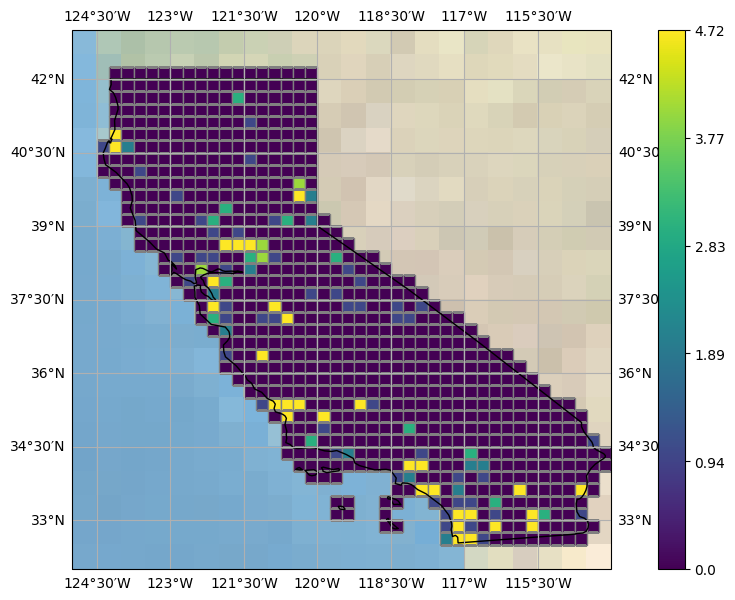

In [15]:
# plot map with lattice of polygons
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_xlim([-125, -114])
ax.set_ylim([32, 43])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)


size = np.log(ca_df.groupby("grid").size())
expected = size.mean()
vmin = size.min()
vmax = size.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))

for key, polygon in polygons.items():
    ax.add_feature(
        cfeature.ShapelyFeature([polygon], projection),
        edgecolor="gray",
        facecolor=color_getter(ca_df[ca_df.grid == key].shape[0]),
    )

ax.add_feature(
    cfeature.ShapelyFeature([california.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"))
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)
ax.stock_img()
plt.show()